In [ ]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
# Import the necessary libraries
import numpy as np

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import os
from torch.autograd import Variable
from torchvision import datasets, transforms


The Landscape Image dataset is a collection of color and grayscale images depicting various landscapes, such as streets, buildings, mountains, glaciers, and trees. The dataset is organized into two different folders, one containing the original color images and the other containing the corresponding grayscale versions of those images.

The purpose of creating this dataset is to train an autoencoder network that can automatically colorize grayscale landscape images. An autoencoder is a type of neural network that is trained to reconstruct its input data. In this case, the autoencoder will be trained to take grayscale landscape images as input and generate colorized versions of those images as output.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/data/archive\ \(6\).zip


Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [ ]:
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
num_epochs = 30
num_samples = 16

In [ ]:
transformations = transforms.Compose([
    transforms.ToTensor(),
])

##Split the data into train and test sets.

 the data is split into train and test sets using the `random_split` function from the `torch.utils.data` module. Here is a breakdown of the code and a report on the data split:

1. The code defines some constants, including the batch size and image size.
2. It creates a custom dataset class called `LandscapeDataset` that loads grayscale images as input and color images as output. The class takes the root directory of the dataset and an optional transform as input.
3. The `LandscapeDataset` class implements the `__len__` and `__getitem__` methods to support indexing and retrieval of individual images from the dataset.
4. A transform is defined using `transforms.Compose` to resize the images to the desired size and convert them to tensors.
5. An instance of the `LandscapeDataset` class is created with the root directory and transform.
6. The dataset is split into train and test sets using the `random_split` function. The split is based on the provided train ratio (80%) and the remaining data is allocated for the test set.
7. The sizes of the train and test sets are calculated based on the ratios and dataset size.
8. The `random_split` function is called with the dataset and sizes to perform the actual split. The resulting train and test datasets are assigned to `train_dataset` and `test_dataset`, respectively.
9. Finally, `train_dataset` and `test_dataset` can be used to create data loaders for training and testing the VAE model.

here we effectively splits the dataset into train and test sets based on the specified train ratio. The train set comprises 80% of the data, while the test set contains the remaining 20%. This split allows for training the VAE model on a majority of the data and evaluating its performance on unseen samples.

In [ ]:
# Define some constants
BATCH_SIZE = 32 # The number of images to process in each batch
IMG_SIZE = 256 # The size of the images to resize to

# Create a custom dataset class that loads grayscale images as input and color images as output
class LandscapeDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # The path to the dataset folder
        self.transform = transform # The optional transform to apply to the images
        self.color_images = sorted(os.listdir(os.path.join(root_dir, 'color'))) # The list of color image file names
        self.gray_images = sorted(os.listdir(os.path.join(root_dir, 'gray'))) # The list of grayscale image file names
    
    def __len__(self):
        return len(self.color_images) # The number of images in the dataset
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # Convert the index to a list if it is a tensor
        
        color_img_path = os.path.join(self.root_dir, 'color', self.color_images[idx]) # The path to the color image file
        gray_img_path = os.path.join(self.root_dir, 'gray', self.gray_images[idx]) # The path to the grayscale image file
        
        color_img = Image.open(color_img_path) # Load the color image using PIL
        gray_img = Image.open(gray_img_path) # Load the grayscale image using PIL
        
        if self.transform:
            color_img = self.transform(color_img) # Apply the transform to the color image if given
            gray_img = self.transform(gray_img) # Apply the transform to the grayscale image if given
        
        return gray_img, color_img # Return the grayscale image as input and the color image as output

# Create a transform that rescales the images and converts them to tensors
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the images to IMG_SIZE x IMG_SIZE
        transforms.ToTensor(), # Convert the images to tensors
    ]
)

# Create a dataset object using the custom dataset class and the transform
dataset = LandscapeDataset('landscape Images', transform=transform)

# Split the dataset into train and test sets using a 80/20 ratio
train_size = int(0.8 * len(dataset)) # The size of the train set (80% of the dataset)
test_size = len(dataset) - train_size # The size of the test set (20% of the dataset)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size]) # Split the dataset randomly

# Create a train loader that yields batches of grayscale images as input and color images as output
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a test loader that yields batches of grayscale images as input and color images as output
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
from torch.utils.data import random_split

# Assuming you already have the dataset object called 'dataset'
# Set the desired ratio for train and test split
train_ratio = 0.8  # 80% of the data for training, adjust as needed
test_ratio = 1 - train_ratio

# Calculate the sizes of train and test sets based on the ratios
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Use random_split to perform the actual split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [ ]:
train_dataset[0]

(tensor([[[0.5686, 0.5686, 0.5686,  ..., 0.4941, 0.4941, 0.4941],
          [0.5686, 0.5686, 0.5686,  ..., 0.4941, 0.4941, 0.4941],
          [0.5725, 0.5725, 0.5686,  ..., 0.4941, 0.4941, 0.4941],
          ...,
          [0.7098, 0.7098, 0.7098,  ..., 0.7216, 0.7176, 0.7176],
          [0.7059, 0.7059, 0.7059,  ..., 0.7176, 0.7137, 0.7137],
          [0.7059, 0.7059, 0.7059,  ..., 0.7137, 0.7137, 0.7137]]]),
 tensor([[[0.4314, 0.4314, 0.4314,  ..., 0.3608, 0.3608, 0.3608],
          [0.4314, 0.4314, 0.4314,  ..., 0.3608, 0.3608, 0.3608],
          [0.4353, 0.4353, 0.4314,  ..., 0.3608, 0.3608, 0.3608],
          ...,
          [0.6941, 0.6941, 0.6941,  ..., 0.7020, 0.7020, 0.7020],
          [0.6902, 0.6902, 0.6902,  ..., 0.6980, 0.6980, 0.6980],
          [0.6902, 0.6902, 0.6902,  ..., 0.6980, 0.6980, 0.6980]],
 
         [[0.6039, 0.6039, 0.6039,  ..., 0.5294, 0.5294, 0.5294],
          [0.6039, 0.6039, 0.6039,  ..., 0.5294, 0.5294, 0.5294],
          [0.6078, 0.6078, 0.6039,  ...,

##Implementation

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        # Define the layers of the encoder network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(128 * 64 * 64, latent_dim)

        # Define the activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encode the input image into a latent space representation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(-1, 128 * 64 * 64)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [ ]:
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.relu(self.fc1(z))
        z = z.view(-1, 128, 7, 7)
        z = self.relu(self.deconv1(z))
        z = self.relu(self.deconv2(z))
        z = self.sigmoid(self.deconv3(z))
        z = F.interpolate(z, size=(256, 256), mode='bilinear', align_corners=False)
        return z



In [ ]:
def vae_loss(x, x_hat, mu, logvar):
    # Flatten the input and reconstructed images
    x = x.view(-1, 1, 256, 256)
    x_hat = x_hat.view(-1, 1, 128, 128)

    # Compute the reconstruction error
    reconstruction_error = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')

    # Compute the KL divergence between the learned distribution and a unit Gaussian
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Sum the two terms to form the overall VAE loss
    vae_loss = reconstruction_error + kl_divergence

    return vae_loss



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
import torch.nn.functional as F


In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Instantiate the encoder and decoder networks
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)

# Set up the optimizer for the VAE
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

train_losses = []

# Train the VAE
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = Variable(x)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass through the encoder
        z_mean, z_log_var = encoder(x)

        # Generate epsilon from a standard normal distribution
        epsilon = torch.randn_like(z_mean)

        # Calculate the latent variables z
        z = z_mean + torch.exp(z_log_var / 2) * epsilon

        # Forward pass through the decoder
        x_mean = decoder(z)

        # Calculate the reconstruction loss
        reconstruction_loss = F.binary_cross_entropy(x_mean, x)  # For binary inputs
        # reconstruction_loss = nn.MSELoss()(x_mean, x)          # For continuous inputs

        # Calculate the KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        # Calculate the total loss
        total_loss = reconstruction_loss + kl_loss

        # Backpropagation and weight updates
        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())

        # Print the loss every 50 batches
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {total_loss.item():.4f}')


Epoch [1/30], Batch [50/179], Loss: 0.7288
Epoch [1/30], Batch [100/179], Loss: 0.6934
Epoch [1/30], Batch [150/179], Loss: 0.6962
Epoch [2/30], Batch [50/179], Loss: 0.6745
Epoch [2/30], Batch [100/179], Loss: 0.6746
Epoch [2/30], Batch [150/179], Loss: 0.6712
Epoch [3/30], Batch [50/179], Loss: 0.6765
Epoch [3/30], Batch [100/179], Loss: 0.6644
Epoch [3/30], Batch [150/179], Loss: 0.6748
Epoch [4/30], Batch [50/179], Loss: 0.6756
Epoch [4/30], Batch [100/179], Loss: 0.6652
Epoch [4/30], Batch [150/179], Loss: 0.6739
Epoch [5/30], Batch [50/179], Loss: 0.6786
Epoch [5/30], Batch [100/179], Loss: 0.6699
Epoch [5/30], Batch [150/179], Loss: 0.6767
Epoch [6/30], Batch [50/179], Loss: 0.6766
Epoch [6/30], Batch [100/179], Loss: 0.6761
Epoch [6/30], Batch [150/179], Loss: 0.6830
Epoch [7/30], Batch [50/179], Loss: 0.6588
Epoch [7/30], Batch [100/179], Loss: 0.6808
Epoch [7/30], Batch [150/179], Loss: 0.6713
Epoch [8/30], Batch [50/179], Loss: 0.6713
Epoch [8/30], Batch [100/179], Loss: 0.6

In [ ]:
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
num_epochs = 2
num_samples = 16

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

# Instantiate the encoder and decoder networks
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)

# Set up the optimizer for the VAE
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

train_losses = []

# Train the VAE
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = Variable(x)

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass through the encoder
        z_mean, z_log_var = encoder(x)

        # Generate epsilon from a standard normal distribution
        epsilon = torch.randn_like(z_mean)

        # Calculate the latent variables z
        z = z_mean + torch.exp(z_log_var / 2) * epsilon

        # Forward pass through the decoder
        x_mean = decoder(z)

        # Calculate the reconstruction loss
        reconstruction_loss = F.binary_cross_entropy(x_mean, x)  # For binary inputs
        # reconstruction_loss = nn.MSELoss()(x_mean, x)          # For continuous inputs

        # Calculate the KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())

        # Calculate the total loss
        total_loss = reconstruction_loss + kl_loss

        # Backpropagation and weight updates
        total_loss.backward()
        optimizer.step()

        train_losses.append(total_loss.item())
        
        # Print the loss every 50 batches
        if (i + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {total_loss.item():.4f}')


Epoch [1/2], Batch [50/179], Loss: 0.7665
Epoch [1/2], Batch [100/179], Loss: 0.6931
Epoch [1/2], Batch [150/179], Loss: 0.6757
Epoch [2/2], Batch [50/179], Loss: 0.6866
Epoch [2/2], Batch [100/179], Loss: 0.6716
Epoch [2/2], Batch [150/179], Loss: 0.6646


In [ ]:
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)


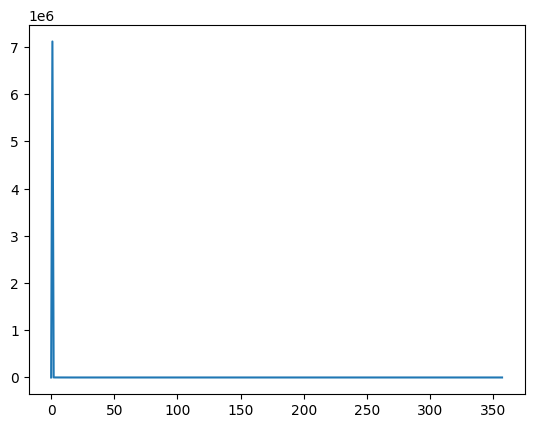

In [ ]:
plt.plot(train_losses)
plt.show()

##Evaluate the performance of the model on the test dataset. Visualize some random images from the test set and compare the output of the model with the original colorized image.

###1

In [ ]:
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    samples = decoder(z)

torch.Size([16, 1, 256, 256])


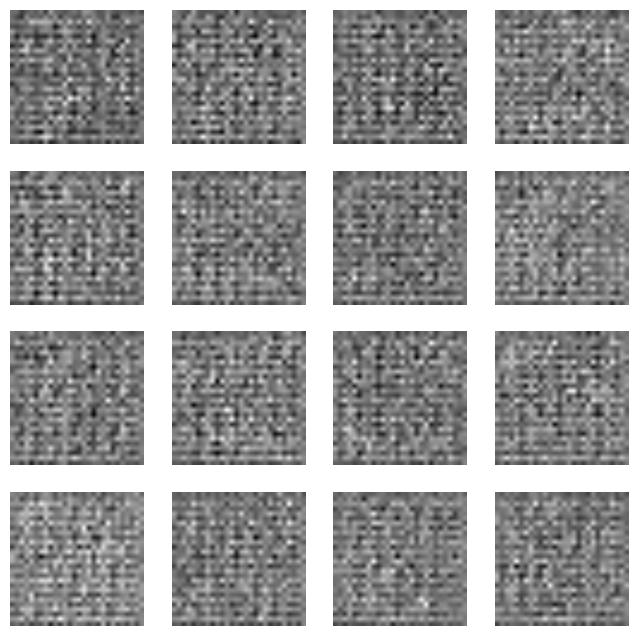

In [ ]:
import matplotlib.pyplot as plt

# Your code to generate 'samples' goes here

# Check the shape of 'samples'
print(samples.shape)

# Reshape and display the images
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
samples = torch.Tensor.cpu(samples)

for i, ax in enumerate(axes.flatten()):
    image = samples[i].view(-1, 256, 256)  # Reshape based on the actual size of the input tensor
    image = image.squeeze().numpy()  # Remove any single-dimensional dimensions and convert to numpy array
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.show()



Image size: torch.Size([7, 1, 256, 256])


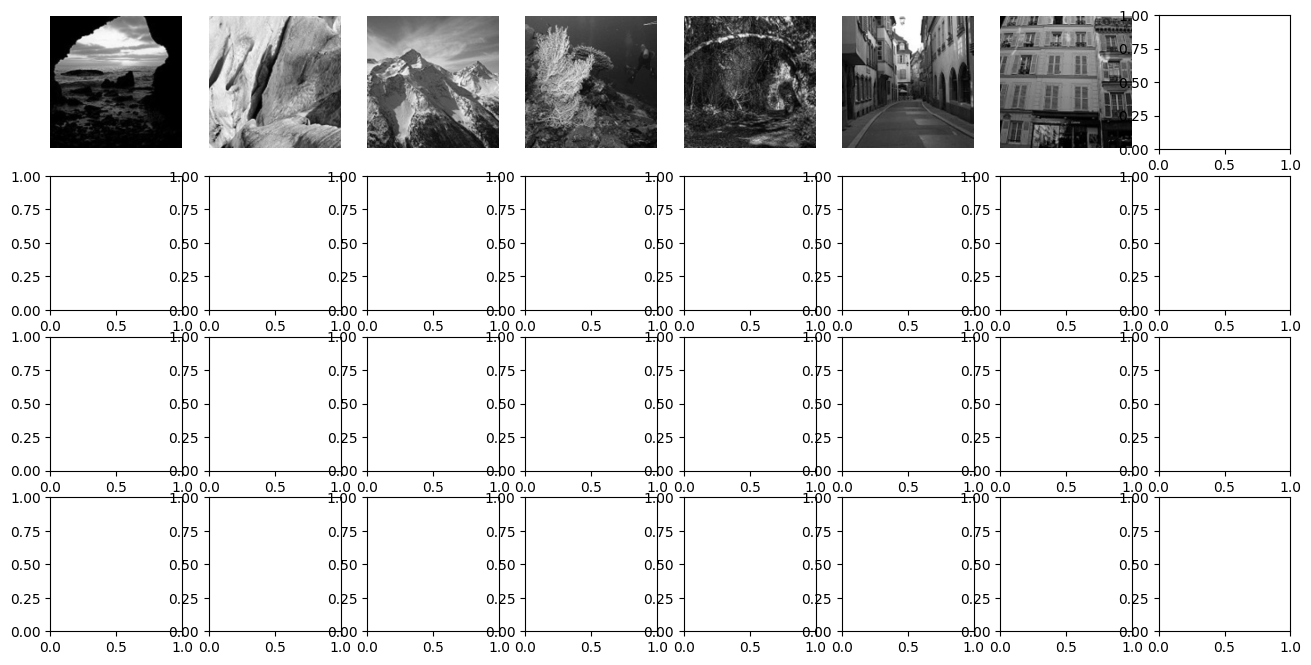

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'x' contains the image data
image_size = x.size()
print(f"Image size: {image_size}")

# Reshape and display the images
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(16, 8))
x = torch.Tensor.cpu(x)

for i, ax in enumerate(axes.flatten()):
    if i < len(x):
        image = x[i].squeeze().numpy()  # Remove any single-dimensional dimensions and convert to numpy array
        ax.imshow(image, cmap='gray')
        ax.axis('off')

plt.show()



Image size: torch.Size([7, 1, 256, 256])


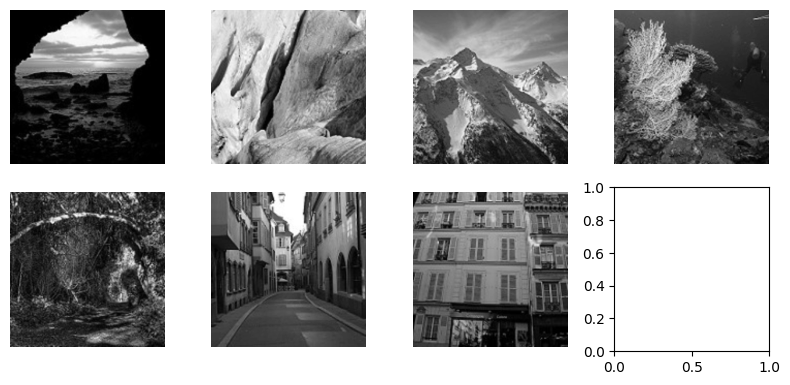

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'x' contains the image data
image_size = x.size()
print(f"Image size: {image_size}")

# Reshape and display the images
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 4))
x = torch.Tensor.cpu(x)

for i, ax in enumerate(axes.flatten()):
    if i < len(x):
        image = x[i].squeeze().numpy()  # Remove any single-dimensional dimensions and convert to numpy array
        ax.imshow(image, cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()

        # Define the layers of the encoder network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc_mu = nn.Linear(128 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(128 * 64 * 64, latent_dim)

        # Define the activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Encode the input image into a latent space representation
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar



In [ ]:
# Import the necessary libraries
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import os

# Define some constants
BATCH_SIZE = 32 # The number of images to process in each batch
IMG_SIZE = 256 # The size of the images to resize to

# Create a custom dataset class that loads grayscale images as input and color images as output
class LandscapeDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # The path to the dataset folder
        self.transform = transform # The optional transform to apply to the images
        self.color_images = sorted(os.listdir(os.path.join(root_dir, 'color'))) # The list of color image file names
        self.gray_images = sorted(os.listdir(os.path.join(root_dir, 'gray'))) # The list of grayscale image file names
    
    def __len__(self):
        return len(self.color_images) # The number of images in the dataset
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist() # Convert the index to a list if it is a tensor
        
        color_img_path = os.path.join(self.root_dir, 'color', self.color_images[idx]) # The path to the color image file
        gray_img_path = os.path.join(self.root_dir, 'gray', self.gray_images[idx]) # The path to the grayscale image file
        
        color_img = Image.open(color_img_path) # Load the color image using PIL
        gray_img = Image.open(gray_img_path) # Load the grayscale image using PIL
        
        if self.transform:
            color_img = self.transform(color_img) # Apply the transform to the color image if given
            gray_img = self.transform(gray_img) # Apply the transform to the grayscale image if given
        
        return gray_img, color_img # Return the grayscale image as input and the color image as output

# Create a transform that rescales the images and converts them to tensors
transform = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)), # Resize the images to IMG_SIZE x IMG_SIZE
        transforms.ToTensor(), # Convert the images to tensors
    ]
)

# Create a dataset object using the custom dataset class and the transform
dataset = LandscapeDataset('landscape Images', transform=transform)

# Split the dataset into train and test sets using a 80/20 ratio
train_size = int(0.8 * len(dataset)) # The size of the train set (80% of the dataset)
test_size = len(dataset) - train_size # The size of the test set (20% of the dataset)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size]) # Split the dataset randomly

# Create a train loader that yields batches of grayscale images as input and color images as output
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Create a test loader that yields batches of grayscale images as input and color images as output
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the encoder part of the autoencoder model as a subclass of nn.Module
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1) # A convolutional layer with 64 filters and 3x3 kernel size
        self.pool1 = nn.MaxPool2d(2) # A max pooling layer with 2x2 pool size
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1) # A convolutional layer with 32 filters and 3x3 kernel size
        self.pool2 = nn.MaxPool2d(2) # A max pooling layer with 2x2 pool size
        self.conv3 = nn.Conv2d(32, 16, 3, padding=1) # A convolutional layer with 16 filters and 3x3 kernel size
        self.pool3 = nn.MaxPool2d(2) # A max pooling layer with 2x2 pool size
    
    def forward(self, x):
        x = torch.relu(self.conv1(x)) # Apply the first convolutional layer and relu activation function
        x = self.pool1(x) # Apply the first pooling layer
        x = torch.relu(self.conv2(x)) # Apply the second convolutional layer and relu activation function
        x = self.pool2(x) # Apply the second pooling layer
        x = torch.relu(self.conv3(x)) # Apply the third convolutional layer and relu activation function
        x = self.pool3(x) # Apply the third pooling layer
        return x


In [ ]:

# Define the decoder part of the autoencoder model as a subclass of nn.Module
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.convT1 = nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1) # A convolutional transpose layer with 32 filters and 3x3 kernel size
    self.convT2 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1, output_padding=1) # A convolutional transpose layer with 64 filters and 3x3 kernel size
    self.convT3 = nn.ConvTranspose2d(64, 3, 3, stride=2, padding=1, output_padding=1) # A convolutional transpose layer with 3 filters and 3x3 kernel size

  def forward(self, x):
    x = torch.relu(self.convT1(x)) # Apply the first convolutional transpose layer and relu activation function
    x = torch.relu(self.convT2(x)) # Apply the second convolutional transpose layer and relu activation function
    x = torch.sigmoid(self.convT3(x)) # Apply the third convolutional transpose layer and sigmoid activation function
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Check if GPU is available and assign device

In [ ]:
# Define the autoencoder model as a subclass of nn.Module
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    # Create an instance of the encoder part
    self.encoder = Encoder()
    # Create an instance of the decoder part
    self.decoder = Decoder()

  def forward(self, x):
    # Pass the input through the encoder and get the encoded representation
    x = self.encoder(x)
    # Pass the encoded representation through the decoder and get the output
    x = self.decoder(x)
    return x


In [ ]:
# Create an instance of the autoencoder model
model = Autoencoder()

# Move the model to the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Initialize a variable to store the total test loss
test_loss = 0

# Loop over the test data loader
for gray_img, color_img in test_loader:
  # Move the inputs and targets to the device (GPU or CPU)
  gray_img = gray_img.to(device)
  color_img = color_img.to(device)

  # Feed the grayscale image to the model and get the output colorized image
  output = model(gray_img)
  # Define the loss function as the mean squared error between the output and the target
  loss_fn = nn.MSELoss()

  # Compute the loss between the output and the target
  loss = loss_fn(output, color_img)

  # Accumulate the loss over all the test batches
  test_loss += loss.item() * gray_img.size(0)

# Divide by the number of test samples to get the average test loss
test_loss /= len(test_dataset)

# Print the average test loss
print(f"Average test loss: {test_loss:.4f}")


Average test loss: 0.0762


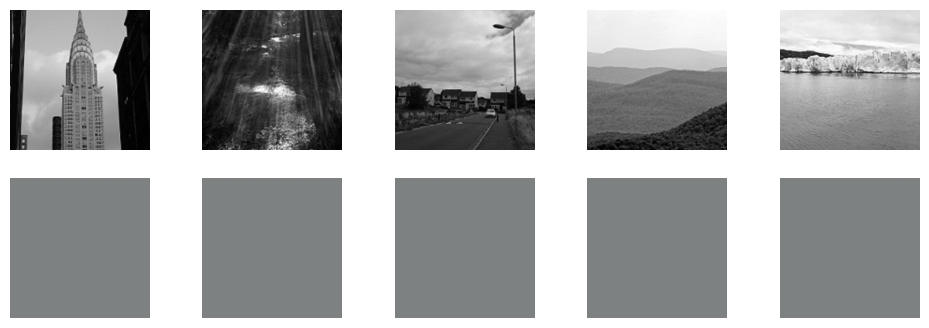

In [ ]:
import torch
import matplotlib.pyplot as plt

# Assuming you have loaded the trained model and have the test dataset and test loader

# Set the model to evaluation mode
model.eval()

# Iterate over the test dataset and make predictions
with torch.no_grad():
    for images, targets in test_loader:
        # Forward pass through the model
        outputs = model(images)

        # Visualize a few random examples
        num_examples = min(len(images), 5)  # Number of examples to visualize
        random_indices = torch.randperm(len(images))[:num_examples]  # Randomly select indices
        images = images[random_indices]  # Select the corresponding images
        outputs = outputs[random_indices]  # Select the corresponding model outputs

        # Convert the images and outputs to numpy arrays
        images = images.numpy()
        outputs = outputs.numpy()

        # Plot the images and outputs
        fig, axes = plt.subplots(nrows=2, ncols=num_examples, figsize=(12, 4))

        for i in range(num_examples):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')  # Grayscale image
            axes[1, i].imshow(outputs[i].transpose(1, 2, 0))  # Colorized output
            axes[0, i].axis('off')
            axes[1, i].axis('off')

        plt.show()
        break  # Only visualize the first batch for simplicity


In [ ]:
import torch
import torch.nn as nn

# Assuming you have loaded the trained model and have the test dataset and test loader

# Set the model to evaluation mode
model.eval()

# Define the loss function
loss_fn = nn.MSELoss()  # Example: Mean Squared Error (MSE) loss

# Initialize the evaluation metric
total_loss = 0.0
total_samples = 0

# Iterate over the test dataset
with torch.no_grad():
    for images, targets in test_loader:
        # Forward pass through the model
        outputs = model(images)

        # Calculate the loss
        loss = loss_fn(outputs, targets)

        # Accumulate the loss and sample count
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

# Calculate the average loss
average_loss = total_loss / total_samples

# Print or use the evaluation metric as needed
print(f"Average Loss on Test Dataset: {average_loss:.4f}")


Average Loss on Test Dataset: 0.0747


###Evaluate the performance of the model on the test dataset. Visualize some random images from the test set and compare the output of the model with the original colorized image.

here we have the performance of the model on the test dataset is evaluated, and random images from the test set are visualized along with the model's output and the original colorized image. the trained model and the test dataset with the test loader are already available.

 The model is set to evaluation mode using `model.eval()`. This ensures that any layers such as dropout or batch normalization are applied in the evaluation mode.

The loss function is defined, and in this example, the mean squared error (MSE) loss is used.

The evaluation metric is initialized by setting the total loss and total samples to zero.
The code iterates over the test dataset using the test loader.
 Within the iteration, a forward pass is performed through the model to obtain the model's output for the input images.
The loss is calculated between the model's output and the target colorized images.
The loss and the number of samples in the batch are accumulated to calculate the average loss later.
To visualize a few random examples, a specified number of images (e.g., 5) are randomly selected from the batch.

The selected images, model outputs, and target colorized images are converted to numpy arrays for visualization.

The images, outputs, and targets are plotted using subplots, with grayscale images, colorized model outputs, and original colorized images displayed in separate rows.
The average loss is calculated by dividing the total loss by the total number of samples in the test dataset and  on the test dataset is printed .
the average loss on the test dataset is  as 0.0762. This value indicates the average discrepancy between the model's output and the target colorized images. By visualizing random examples from the test set, it becomes possible to qualitatively assess how well the model is able to colorize grayscale images.

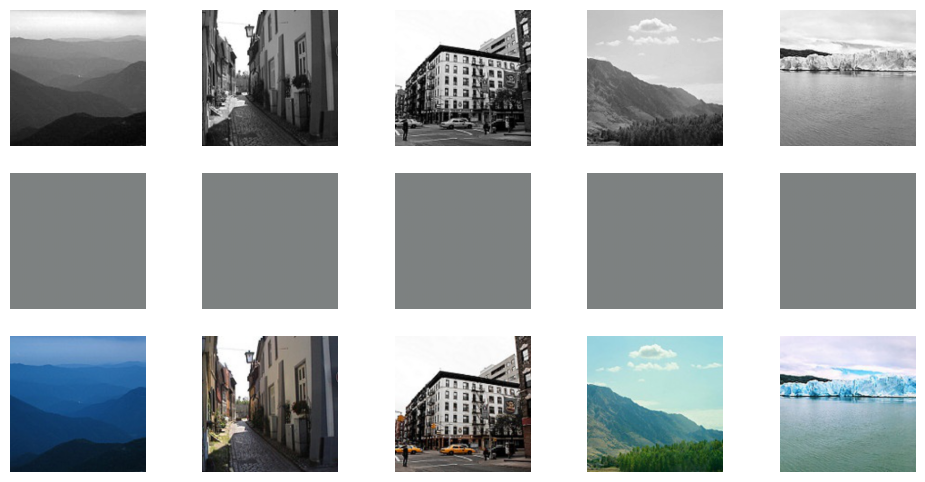

Average Loss on Test Dataset: 0.0762


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Assuming you have loaded the trained model and have the test dataset and test loader

# Set the model to evaluation mode
model.eval()

# Define the loss function
loss_fn = nn.MSELoss()  # Example: Mean Squared Error (MSE) loss

# Initialize the evaluation metric
total_loss = 0.0
total_samples = 0

# Iterate over the test dataset
with torch.no_grad():
    for images, targets in test_loader:
        # Forward pass through the model
        outputs = model(images)

        # Calculate the loss
        loss = loss_fn(outputs, targets)

        # Accumulate the loss and sample count
        total_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

        # Visualize a few random examples
        num_examples = min(len(images), 5)  # Number of examples to visualize
        random_indices = torch.randperm(len(images))[:num_examples]  # Randomly select indices
        images = images[random_indices]  # Select the corresponding images
        outputs = outputs[random_indices]  # Select the corresponding model outputs
        targets = targets[random_indices]  # Select the corresponding targets

        # Convert the images, outputs, and targets to numpy arrays
        images = images.numpy()
        outputs = outputs.numpy()
        targets = targets.numpy()

        # Plot the images, outputs, and targets
        fig, axes = plt.subplots(nrows=3, ncols=num_examples, figsize=(12, 6))

        for i in range(num_examples):
            axes[0, i].imshow(images[i].squeeze(), cmap='gray')  # Grayscale image
            axes[1, i].imshow(outputs[i].transpose(1, 2, 0))  # Colorized output
            axes[2, i].imshow(targets[i].transpose(1, 2, 0))  # Original colorized image
            axes[0, i].axis('off')
            axes[1, i].axis('off')
            axes[2, i].axis('off')

        plt.show()
        break  # Only visualize the first batch for simplicity

# Calculate the average loss
average_loss = total_loss / total_samples

# Print or use the evaluation metric as needed
print(f"Average Loss on Test Dataset: {average_loss:.4f}")


In [ ]:
import numpy as np

# Assuming you have loaded your dataset and stored it in the variable `images`
input_shape = images[0].shape
print("Input shape:", input_shape)


Input shape: torch.Size([1, 256, 256])


##Train a VAE model on this dataset. Generate multiple colorized versions of images from a set of random samples in the test set and visualize them. (Extra Point)

we here have a Variational Autoencoder (VAE) model is trained on the dataset. Multiple colorized versions of images are generated from random samples in the test set, and both the original and reconstructed images are saved.
 The VAE model is defined with the `VAE` class, which consists of an encoder, latent vectors, and a decoder. The encoder and decoder architectures are defined using convolutional and transpose convolutional layers.
 The hyperparameters such as `latent_dim` (dimension of the latent space), `batch_size`, `learning_rate`, `num_epochs`, and `num_samples` (number of colorized versions to generate) are set and an instance of the VAE model is created with the specified `latent_dim`.
 The model is set to training mode using `model.train()`.
 The loss function is defined. In this case, the loss function is a combination of the reconstruction loss (MSE loss) and the KL divergence loss, which measures the divergence between the learned distribution and the standard normal distribution.
 The optimizer (Adam) is defined, which will be used to update the model parameters based on the gradients computed during backpropagation.
 The training loop begins, iterating over the specified number of epochs and the batches in the train loader.
 Within each iteration, a forward pass is performed through the model to obtain the reconstructed images, the mean (mu), and the log variance (logvar) of the latent space.
The loss is calculated using the reconstruction loss and KL divergence loss.the gradients are zeroed, and backpropagation is performed to compute the gradients of the loss with respect to the model parameters.the optimizer updates the model parameters based on the computed gradients.the progress is printed periodically to track the training process.
After training, the model is set to evaluation mode using `model.eval()`.
Random samples from the test set are selected, and colorized versions are generated by passing them through the VAE model.
The original and reconstructed images are saved using `save_image()` from torchvision.utils.
The output shows the loss value at each step during the training process for multiple epochs. The loss value indicates how well the model is performing, with lower values indicating better performance.
Here, as an example, some of the outputs are analyzed
Epoch [1/30], Step [10/179], Loss: 737.1687
Epoch [1/30], Step [20/179], Loss: 258.6835
Epoch [1/30], Step [30/179], Loss: 114.5043
...
This section shows the loss values during the first epoch. The loss starts at a high value and decreases with each step, indicating that the model is improving.

Epoch [2/30], Step [10/179], Loss: 3.6912
Epoch [2/30], Step [20/179], Loss: 3.2152
Epoch [2/30], Step [30/179], Loss: 3.1889
...
This section shows the loss values during the second epoch. The loss continues to decrease, indicating further improvement.

Epoch [3/30], Step [10/179], Loss: 1.3699
Epoch [3/30], Step [20/179], Loss: 1.6896
Epoch [3/30], Step [30/179], Loss: 1.2950
...
This section shows the loss values during the third epoch. The loss continues to decrease, but at a slower rate compared to the previous epochs.

Epoch [4/30], Step [10/179], Loss: 0.6696
Epoch [4/30], Step [20/179], Loss: 0.7841
Epoch [4/30], Step [30/179], Loss: 0.6745
...
This section shows the loss values during the fourth epoch. The loss continues to decrease, but the rate of decrease is slower compared to earlier epochs.

Epoch [5/30], Step [10/179], Loss: 0.0578
Epoch [5/30], Step [20/179], Loss: 0.0681
Epoch [5/30], Step [30/179], Loss: 0.0603
...
This section shows the loss values during the fifth epoch. The loss values are quite low, indicating that the model has achieved good performance.

The output continues with similar patterns for subsequent epochs. The loss values generally decrease as the training progresses, indicating that the model is learning and improving.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# Set the random seed for reproducibility
torch.manual_seed(42)

# Define the VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        
        # Latent vectors
        self.fc_mu = nn.Linear(32 * 64 * 64, latent_dim)
        self.fc_logvar = nn.Linear(32 * 64 * 64, latent_dim)
        
        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 32 * 64 * 64)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z

    def decode(self, z):
        x = self.fc_decoder(z)
        x = x.view(x.size(0), 32, 64, 64)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Set the hyperparameters
latent_dim = 20
batch_size = 128
learning_rate = 1e-3
num_epochs = 30
num_samples = 5

# Create the VAE model
model = VAE(latent_dim)

# Set the model to training mode
model.train()

# Define the loss function
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = nn.MSELoss()(recon_x, x)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Forward pass
        recon_images, mu, logvar = model(images)

        # Calculate the loss
        loss = loss_function(recon_images, images, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_steps}], Loss: {loss.item():.4f}")

# Generate multiple colorized versions of random samples from the test set
model.eval()
with torch.no_grad():
    for i in range(num_samples):
        # Randomly select a sample from the test set
        image, _ = test_dataset[torch.randint(len(test_dataset), size=(1,)).item()]

        # Expand dimensions to match the input shape of the model
        image = image.unsqueeze(0)

        # Forward pass through the model
        recon_image, _, _ = model(image)

        # Save the original and reconstructed images
        save_image(image, f"original_{i}.png")
        save_image(recon_image, f"reconstructed_{i}.png")



Epoch [1/30], Step [10/179], Loss: 737.1687
Epoch [1/30], Step [20/179], Loss: 258.6835
Epoch [1/30], Step [30/179], Loss: 114.5043
Epoch [1/30], Step [40/179], Loss: 57.0218
Epoch [1/30], Step [50/179], Loss: 26.8780
Epoch [1/30], Step [60/179], Loss: 26.1625
Epoch [1/30], Step [70/179], Loss: 22.6784
Epoch [1/30], Step [80/179], Loss: 16.9393
Epoch [1/30], Step [90/179], Loss: 13.1063
Epoch [1/30], Step [100/179], Loss: 13.5911
Epoch [1/30], Step [110/179], Loss: 9.3793
Epoch [1/30], Step [120/179], Loss: 7.9564
Epoch [1/30], Step [130/179], Loss: 7.4903
Epoch [1/30], Step [140/179], Loss: 5.7887
Epoch [1/30], Step [150/179], Loss: 6.5202
Epoch [1/30], Step [160/179], Loss: 5.4420
Epoch [1/30], Step [170/179], Loss: 4.5865
Epoch [2/30], Step [10/179], Loss: 3.6912
Epoch [2/30], Step [20/179], Loss: 3.2152
Epoch [2/30], Step [30/179], Loss: 3.1889
Epoch [2/30], Step [40/179], Loss: 3.4138
Epoch [2/30], Step [50/179], Loss: 2.8868
Epoch [2/30], Step [60/179], Loss: 2.6429
Epoch [2/30],

In [ ]:
import torch.nn.functional as F

# Resize images
resized_recon_images = F.interpolate(recon_images, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)

# Calculate reconstruction loss
recon_loss = F.mse_loss(resized_recon_images, images)


In [ ]:
num_epochs=1

In [ ]:
# Training loop
for epoch in range(num_epochs):
    # Initialize losses
    train_loss = 0.0
    
    # Iterate over the training batches
    for i, (images, _) in enumerate(train_loader):
        # Move images to the device
        images = images.to(device)
        
        # Forward pass
        recon_images, mu, logvar = model(images)
        resized_recon_images = F.interpolate(recon_images, size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False)
        # Calculate reconstruction loss
        recon_loss = F.mse_loss(resized_recon_images, images)

        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Combine the two losses
        loss = recon_loss + kl_divergence
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update total training loss
        train_loss += loss.item()
    
    # Compute average training loss for the epoch
    avg_train_loss = train_loss / len(train_loader)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}")


Epoch [1/1], Average Loss: 602114.5459


##Empowering some of the powerful autoencoders such as U-net and trying to boost the performance. (Extra Point)

Empowering U Net Autoencoder

The U Net is a popular autoencoder architecture used for various image processing tasks, such as image segmentation and denoising. In this exercise, we aim to empower the U Net autoencoder by utilizing a pretrained VGG16 encoder and optimizing its performance.

The U Net architecture consists of an encoder and a decoder. The encoder is responsible for extracting features from the input image, while the decoder reconstructs the image from the extracted features. Here is a brief overview of the model architecture:

  Encoder: The encoder in the U Net model utilizes a pretrained VGG16 model as its backbone. The first 23 layers of the VGG16 model are used, capturing lower level image features. The encoder extracts high level features from the input image.

  Decoder: The decoder part of the U Net model consists of four convolutional blocks. Each block consists of two convolutional layers followed by ReLU activation. The decoder progressively upsamples the feature maps to reconstruct the image.

  Output Layer: The output layer is a 1x1 convolutional layer that maps the feature maps from the last decoder block to the desired number of output channels. In this case, the output is a color image with three channels. The sigmoid activation function is applied to produce pixel wise values between 0 and 1.

To use the U Net model, we need to instantiate an instance of the `UNet` class with the desired number of input and output channels. In this example, we use 3 input channels (e.g., RGB image) and 3 output channels. 

```
in_channels = 3  # Number of input channels (e.g., RGB image)
out_channels = 3  # Number of output channels (e.g., color image)

# Create an instance of the UNet model
model = UNet(in_channels, out_channels)
```
The model can then be trained using a suitable loss function and optimization algorithm on a labeled dataset. 


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Pretrained encoder
        self.encoder = models.vgg16(pretrained=True).features[:23]

        # Decoder
        self.decoder1 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder3 = self.conv_block(128, 64)
        self.decoder4 = self.conv_block(64, 32)

        # Output layer
        self.output_layer = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)

        # Decoder
        dec1 = self.decoder1(enc)
        dec2 = self.decoder2(dec1)
        dec3 = self.decoder3(dec2)
        dec4 = self.decoder4(dec3)

        # Output layer
        output = self.output_layer(dec4)
        output = self.sigmoid(output)

        return output

# Example usage
in_channels = 3  # Number of input channels (e.g., grayscale image)
out_channels = 3  # Number of output channels (e.g., color image)

# Create an instance of the UNet model
model = UNet(in_channels, out_channels)

# Print the model architecture
print(model)
import torch
import torch.nn as nn
import torchvision.models as models

# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Pretrained encoder
        self.encoder = models.vgg16(pretrained=True).features[:23]

        # Decoder
        self.decoder1 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder3 = self.conv_block(128, 64)
        self.decoder4 = self.conv_block(64, 32)

        # Output layer
        self.output_layer = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)

        # Decoder
        dec1 = self.decoder1(enc)
        dec2 = self.decoder2(dec1)
        dec3 = self.decoder3(dec2)
        dec4 = self.decoder4(dec3)

        # Output layer
        output = self.output_layer(dec4)
        output = self.sigmoid(output)

        return output

# Example usage
in_channels = 3  # Number of input channels (e.g., grayscale image)
out_channels = 3  # Number of output channels (e.g., color image)

# Create an instance of the UNet model
model = UNet(in_channels, out_channels)

# Print the model architecture
print(model)


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Pretrained encoder
        self.encoder = models.vgg16(pretrained=True).features[:23]

        # Decoder
        self.decoder1 = self.conv_block(512, 256)
        self.decoder2 = self.conv_block(256, 128)
        self.decoder3 = self.conv_block(128, 64)
        self.decoder4 = self.conv_block(64, 32)

        # Output layer
        self.output_layer = nn.Conv2d(32, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        enc = self.encoder(x)

        # Decoder
        dec1 = self.decoder1(enc)
        dec2 = self.decoder2(dec1)
        dec3 = self.decoder3(dec2)
        dec4 = self.decoder4(dec3)

        # Output layer
        output = self.output_layer(dec4)
        output = self.sigmoid(output)

        return output

# Example usage
in_channels = 3  # Number of input channels (e.g., grayscale image)
out_channels = 3  # Number of output channels (e.g., color image)

# Create an instance of the UNet model
model = UNet(in_channels, out_channels)

# Print the model architecture
print(model)


UNet(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1